# Synthetic Data Generation and Analysis

**Objective:** Demonstrate synthetic data generation using WGAN and VAE on tabular datasets, evaluate quality through statistics and visualizations, and showcase applications in classification, forecasting, and change‑point detection.

**Outline:**
1. Overview of the Airline Passenger Satisfaction dataset  
2. Synthetic data generation with WGAN and VAE  
3. Comparative quality analysis (statistics & correlations)  
4. Classification performance: real vs. synthetic vs. mixed  
5. Change-point detection on power consumption  
6. Sliding-window classification (peak vs. normal)  
7. Short-term forecasting with ARIMA  
8. Conclusions and further directions  


## 1. Setup Environment

In [22]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Import generation pipelines

from data_generation.gan import GAN, GanConfig
from data_generation.vae import VAEPipeline, VAEConfig
from models.enums import DataType
from models.field_metadata import FieldMetadata

# For classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Airline Dataset Overview

In [3]:
# Load and inspect the real dataset
real_df = pd.read_csv('datasets/airline-passenger-satisfaction.csv').dropna()
print(f"Shape: {real_df.shape}")
display(real_df.head())

Shape: (103594, 23)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure or Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,is_satisfied
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


## 3. Synthetic Data Generation

Створюємо метадані для GAN та VAE, які описують типи даних та методи генерації

In [4]:
metadata = {
    'Gender': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Customer Type': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Age': FieldMetadata(DataType.INTEGER, sampling='empirical', transformer = 'bounded'),
    'Type of Travel': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Class': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Flight Distance': FieldMetadata(DataType.INTEGER, sampling='empirical', transformer = 'log'),
    'Inflight wifi service': FieldMetadata(DataType.INTEGER),
    'Departure or Arrival time convenient': FieldMetadata(DataType.INTEGER),
    'Ease of Online booking': FieldMetadata(DataType.INTEGER),
    'Gate location': FieldMetadata(DataType.INTEGER),
    'Food and drink': FieldMetadata(DataType.INTEGER),
    'Online boarding': FieldMetadata(DataType.INTEGER),
    'Seat comfort': FieldMetadata(DataType.INTEGER),
    'Inflight entertainment': FieldMetadata(DataType.INTEGER),
    'On-board service': FieldMetadata(DataType.INTEGER),
    'Leg room service': FieldMetadata(DataType.INTEGER),
    'Baggage handling': FieldMetadata(DataType.INTEGER),
    'Checkin service': FieldMetadata(DataType.INTEGER),
    'Inflight service': FieldMetadata(DataType.INTEGER),
    'Cleanliness': FieldMetadata(DataType.INTEGER),
    'Departure Delay in Minutes': FieldMetadata(DataType.INTEGER, sampling='empirical', transformer = 'zero_inflated'),
    'Arrival Delay in Minutes': FieldMetadata(DataType.DECIMAL, decimal_places=1, sampling='empirical', transformer = 'zero_inflated'),
    'is_satisfied': FieldMetadata(DataType.BOOLEAN, sampling='empirical'),
}

Тренуємо GAN та VAE нейромережі з однаковими параметрами, щоб порівняти їх результати

In [5]:
synthetic_size = 50_000  # Number of synthetic samples to generate

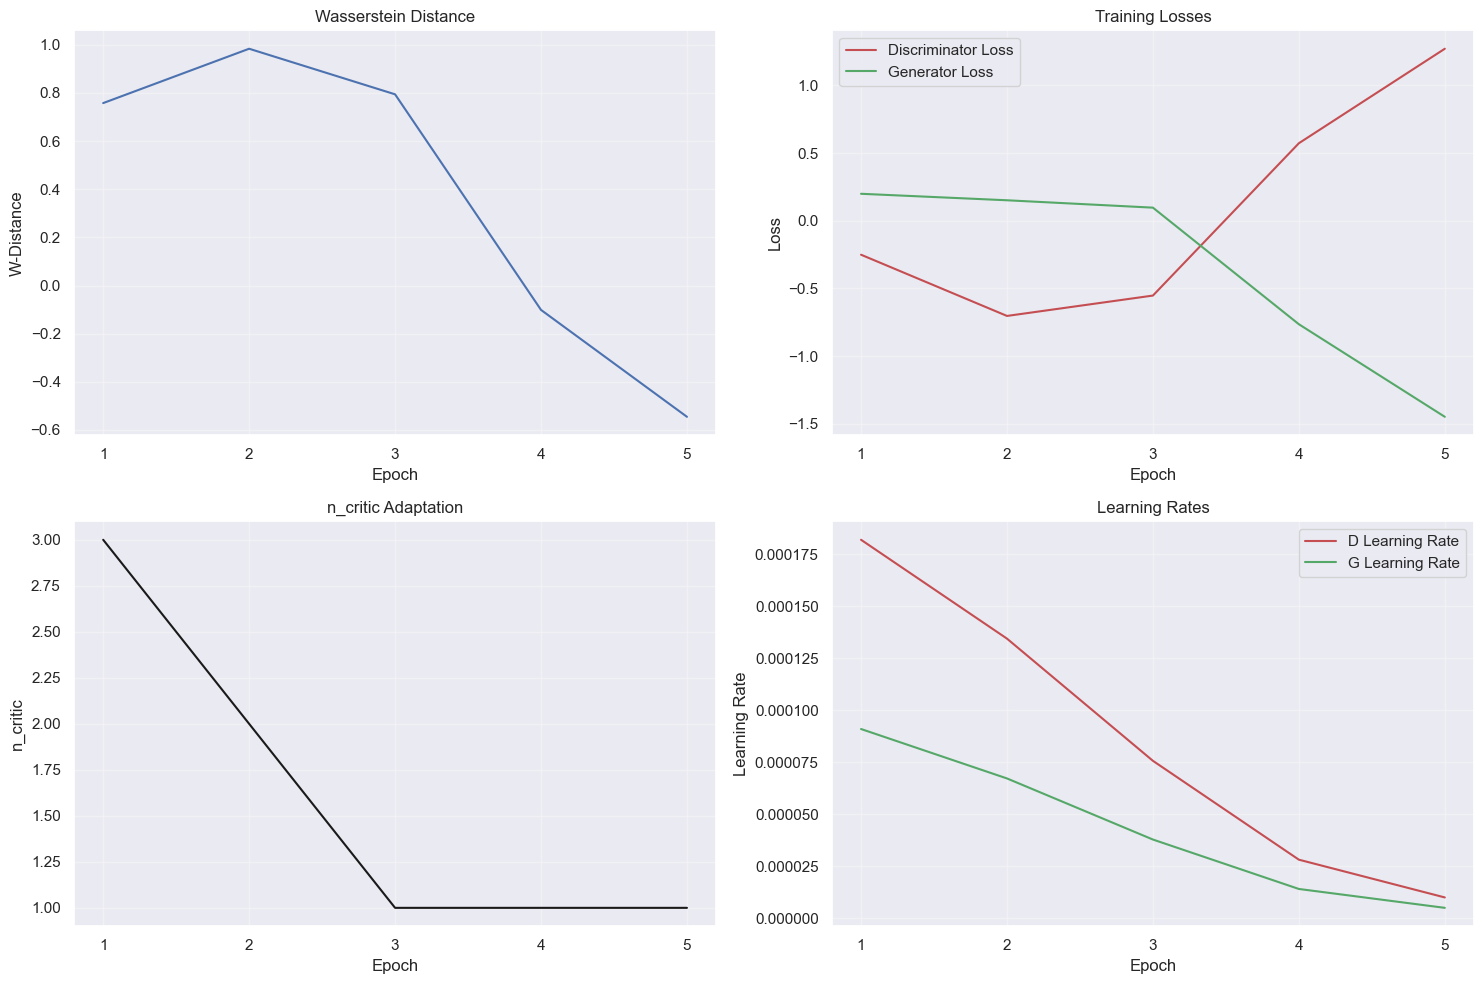

In [12]:
# Creating a GAN pipeline with GAN Config class
generator = GAN(real_df, metadata, GanConfig(epochs=5))
# Training a GAN model with training plots
generator.fit(verbose=True)
# Generating synthetic data
synthetic_data_gan = generator.generate(synthetic_size)

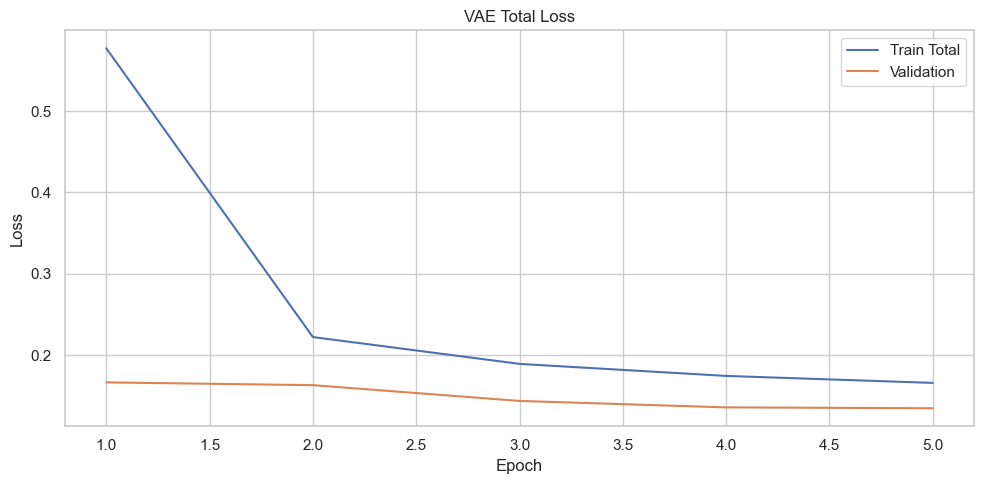

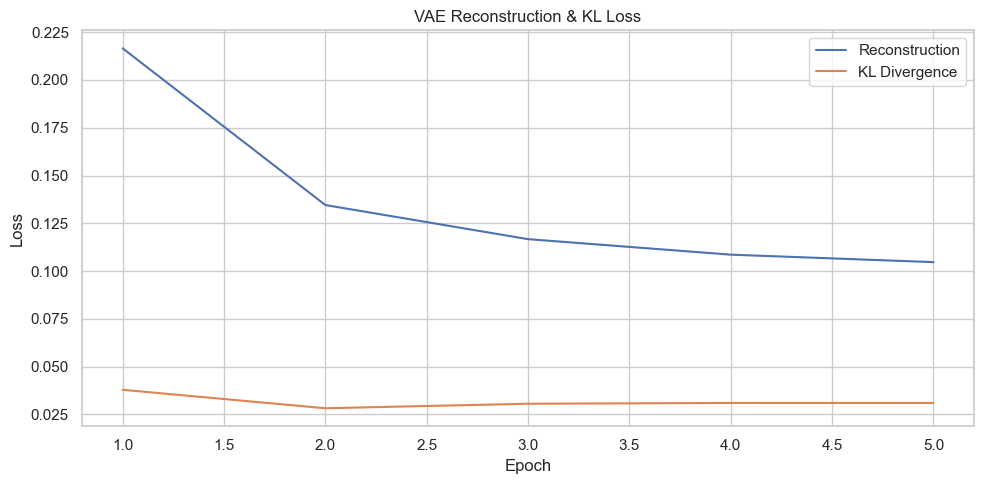

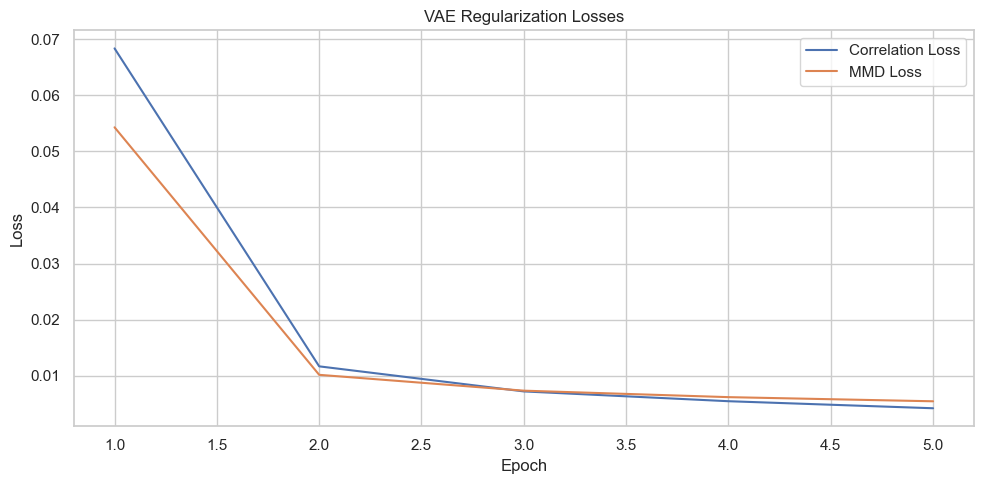

In [23]:
# Creating a VAE pipeline with a VAE Config class
vae_pipe = VAEPipeline(real_df, metadata, VAEConfig(epochs=5))
# Training a VAE model with training plots
vae_pipe.fit(verbose=True)
# Generating synthetic data
synthetic_data_vae = vae_pipe.generate(synthetic_size)

## 4. Quality Analysis

In [ ]:
# 4.1 General statistics
for name, df in [('Real', real), ('GAN', synthetic_gan), ('VAE', synthetic_vae)]:
    print(f"### {name} describe")
    display(df.describe())


In [ ]:
# 4.2 Key categorical distributions
cat_cols = ['Class', 'satisfaction']
for col in cat_cols:
    plt.figure(figsize=(6,3))
    real[col].value_counts(normalize=True).plot(kind='bar', alpha=0.6, label='Real')
    synthetic_gan[col].value_counts(normalize=True).plot(kind='bar', alpha=0.6, label='GAN')
    synthetic_vae[col].value_counts(normalize=True).plot(kind='bar', alpha=0.6, label='VAE')
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()


In [ ]:
# 4.3 Numeric correlation matrices
num_cols = real.select_dtypes(include=[np.number]).columns.tolist()
for name, df in [('Real', real), ('GAN', synthetic_gan), ('VAE', synthetic_vae)]:
    plt.figure(figsize=(6,5))
    sns.heatmap(df[num_cols].corr(), vmin=-1, vmax=1, cmap='vlag')
    plt.title(f'{name} numeric correlations')
    plt.show()


## 5. Classification: Real vs. Synthetic vs. Mixed

In [ ]:
# Prepare preprocessing
NUM_FEATS = num_cols
CAT_FEATS = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
preproc = ColumnTransformer([
    ('num', StandardScaler(), NUM_FEATS),
    ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_FEATS),
])
X_real = real.drop('satisfaction', axis=1)
y_real = (real['satisfaction'] == 'satisfied').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, stratify=y_real, random_state=42)
preproc.fit(X_train)

# Helper to train & evaluate
def run_experiment(X_train_df, y_train_arr, label):
    X_scaled = preproc.transform(X_train_df)
    clf = MLPClassifier(hidden_layer_sizes=(128,64,32), max_iter=300, random_state=42)
    clf.fit(X_scaled, y_train_arr)
    X_test_scaled = preproc.transform(X_test)
    acc = accuracy_score(y_test, clf.predict(X_test_scaled))
    print(f"{label} -> Accuracy: {acc:.4f}")

# 5.1 Real only
run_experiment(X_train, y_train, 'Real')

# 5.2 GAN only
run_experiment(synthetic_gan.drop('satisfaction', axis=1), (synthetic_gan['satisfaction']=='satisfied').astype(int), 'GAN')

# 5.3 VAE only
run_experiment(synthetic_vae.drop('satisfaction', axis=1), (synthetic_vae['satisfaction']=='satisfied').astype(int), 'VAE')

# 5.4 Real + GAN
X_mix, y_mix = pd.concat([X_train, synthetic_gan.drop('satisfaction', axis=1)]), np.hstack([y_train, (synthetic_gan['satisfaction']=='satisfied').astype(int)])
run_experiment(X_mix, y_mix, 'Real+GAN')

# 5.5 Real + VAE
X_mix2, y_mix2 = pd.concat([X_train, synthetic_vae.drop('satisfaction', axis=1)]), np.hstack([y_train, (synthetic_vae['satisfaction']=='satisfied').astype(int)])
run_experiment(X_mix2, y_mix2, 'Real+VAE')


## 6. Change‑Point Detection on Power Consumption

In [ ]:
import ruptures as rpt

# Load and prepare one year
df_power = pd.read_csv('/mnt/data/household_power_consumption.csv', sep=';', parse_dates={'dt':['Date','Time']}, infer_datetime_format=True, na_values='?')
df_hourly = df_power.dropna(subset=['Global_active_power']).set_index('dt').resample('H').sum()
year = df_hourly['2008-01-01':'2008-12-31']['Global_active_power'].reset_index(drop=True)

# Real breakpoints
algo = rpt.Pelt(model='rbf').fit(year.values)
print("Real breakpoints:", algo.predict(pen=10))

# Synthetic via GAN
meta_power = {'Global_active_power': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3)}
gan_p = WGAN(real=year.to_frame(), meta=meta_power, cfg=GanConfig(epochs=100))
gan_p.fit(verbose=False)
S = gan_p.generate(len(year))

# Breakpoints on synthetic
algo_syn = rpt.Pelt(model='rbf').fit(S['Global_active_power'].values)
print("Synthetic breakpoints:", algo_syn.predict(pen=10))


## 7. Sliding‑Window Classification (Peak vs. Normal)

In [ ]:
# Build sliding windows
df_hw = df_power.dropna(subset=['Global_active_power']).set_index('dt').resample('H').sum().reset_index(drop=True)
vals = df_hw['Global_active_power'].values
W_size = 24
windows = np.stack([vals[i:i+W_size] for i in range(len(vals)-W_size+1)])
thr = np.percentile(windows.max(axis=1), 90)
y_real_sw = (windows.max(axis=1) > thr).astype(int)
W_df = pd.DataFrame(windows, columns=[f't{i}' for i in range(W_size)])

# Train GAN and balance
meta_sw = {c: FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3) for c in W_df.columns}
gan_sw = WGAN(real=W_df, meta=meta_sw, cfg=GanConfig(epochs=100))
gan_sw.fit(verbose=False)
n0, n1 = (y_real_sw==0).sum(), (y_real_sw==1).sum()
k = abs(n0-n1)
S_sw = gan_sw.generate(k)
y_syn_sw = np.zeros(k, int) if n0<n1 else np.ones(k, int)

# Train classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
X = np.vstack([W_df.values, S_sw.values])
y = np.hstack([y_real_sw, y_syn_sw])
Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42).fit(Xtr, ytr)
print("RF accuracy:", clf.score(Xte, yte))


## 8. Short‑Term Forecasting with ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Daily aggregation
daily = df_power.dropna(subset=['Global_active_power']).set_index('dt').resample('D').sum().reset_index()
daily = daily.rename(columns={'Global_active_power':'Value'})

# Train GAN
gan_fc = WGAN(real=daily[['Value']], meta={'Value': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3)}, cfg=GanConfig(
    epochs=100))
gan_fc.fit(verbose=False)
S_fc = gan_fc.generate(60)
last_date = daily['dt'].iloc[-1]
S_fc['dt'] = [last_date + pd.Timedelta(days=i+1) for i in range(len(S_fc))]

# Forecast
train_real = daily.set_index('dt')['Value'][:-180]
train_aug = pd.concat([train_real, S_fc.set_index('dt')['Value']])
test = daily.set_index('dt')['Value'][-180:]
def one_step_mae(series, order=(5,1,0)):
    model = ARIMA(series, order=order).fit()
    preds = model.predict(start=test.index[0], end=test.index[-1], dynamic=False)
    return (preds - test).abs().mean()

print("MAE real-only:", one_step_mae(train_real))
print("MAE real+syn :", one_step_mae(train_aug))


## 9. Conclusions & Future Work

- **Quality Check:** Both WGAN and VAE capture key distributions and correlations, with minor deviations.  
- **Classification:** Augmenting real data with synthetics often improves or matches performance, useful for class imbalance.  
- **Applications:** Demonstrated synthetic augmentation for change‑point detection, peak classification, and forecasting.

### Further Directions
- **Anomaly Detection:** Use synthetic data to improve unsupervised anomaly detectors.  
- **Conditional Generation:** Extend models to conditioned on class labels or external covariates.  
- **Privacy Evaluation:** Assess privacy risks (e.g., membership inference).  
- **Hyperparameter Tuning:** Systematic grid search for model stability and quality.  
- **Dimensionality Reduction:** t‑SNE/UMAP visualizations of real vs. synthetic.  
- **Other Domains:** Apply to healthcare, financial, and sensor datasets.  
